Back to the main [Index](../index.ipynb) <a id="top"></a>

<div class="jumbotron">
  <h1 class="display-3">Third (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">Crystalline silicon.</p> 
  <hr class="my-4">
  <p>This lesson aims at showing you how to get the following physical properties, for an insulator:</p>
    
  <ul>
    <li>the total energy</li>
    <li>the lattice parameter</li>
    <li>the Kohn-Sham band structure</li>
  </ul>
  You will learn about the use of k-points, as well as the smearing of the plane-wave kinetic energy cut-off.
  </div>
This tutorial is a complement to the standard [ABINIT tutorial on silicon](https://docs.abinit.org/tutorial/base3). Here, powerful flow and visualisation procedures
will be demonstrated. Still, some basic understanding of the stand-alone working of ABINIT is a prerequisite.
Also, in order to fully benefit from this Abipy tutorial, other more basic Abipy tutorials should have been followed,
as suggested in the [abitutorials index page](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/index.ipynb).

  
## Table of Contents
[[back to top](#top)]

- [Computing the total energy of silicon at fixed number of k-points](#Computing-the-total-energy-of-silicon-at-fixed-number-of-k-points)
- [Analysis of the results](#Analysis-of-the-results)
- [Determination of the lattice parameters](#Determination-of-the-lattice-parameters)
- [Computing the band-structure](#Computing-the-band-structure)

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

## Computing the total energy of silicon at fixed number of k-points
[[back to top](#top)]

Our goal is to study the convergence of the total energy of silicon versus the number of k-points. 
So we start by defining a function that generates a `Flow` of SCF calculations 
by looping over a predefined list of `ngkpt` values.
The crystalline structure is initialized from a CIF file while  other parameters 
such as the cutoff energy are fixed:

In [2]:
from lesson_base3 import build_ngkpt_flow
abilab.print_source(build_ngkpt_flow)

Let's call the function to build the flow:

In [3]:
flow = build_ngkpt_flow(options=None)

In total, we have four `ScfTasks` that will be executed in the `flow_base3_ngkpt` directory:

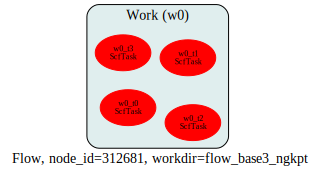

In [4]:
flow.get_graphviz()

This is the input of the first task `w0_t0`:

In [5]:
flow[0][0].input

<AbinitInput at 4611764008>

and these are the divisions of the k-mesh for the four different calculations:

In [6]:
for task in flow.iflat_tasks():
    print(task.pos_str, "uses ngkpt:", task.input["ngkpt"])

w0_t0 uses ngkpt: (2, 2, 2)
w0_t1 uses ngkpt: (4, 4, 4)
w0_t2 uses ngkpt: (6, 6, 6)
w0_t3 uses ngkpt: (8, 8, 8)


but we can achieve the same goal with:

In [9]:
flow.get_vars_dataframe("ngkpt", "ecut")

,ngkpt,ecut
w0_t0,"(2, 2, 2)",8
w0_t1,"(4, 4, 4)",8
w0_t2,"(6, 6, 6)",8
w0_t3,"(8, 8, 8)",8


At this point, we could run the flow in the notebook by just calling:

    flow.make_scheduler().start()

or, alternatively, execute the `lesson_base3.py` script to build 
the directory with the flow and then use:

    abirun.py flow_base3_ngkpt scheduler

inside the terminal.

## Analysis of the results
[[back to top](#top)]

We could use the API provided by the flow to extract the total energies from
the GSR files. Something like:

```python
nkpt_list, ene_list = [], []
for task in flow.iflat_tasks():
    with task.open_gsr() as gsr:
        nkpt_list.append(gsr.nkpt)
        ene_list.append(gsr.energy)
        
# Assuming values are already sorted wrt nkpt
import matplotlib.pyplot as plt
plt.plot(nkpt_list, ene_list, marker="o");
```

but it is much easier to create a `GsrRobot` that will do the work for us:

In [10]:
robot_enekpt = abilab.GsrRobot.from_dir("flow_base3_ngkpt")
robot_enekpt

Label                     Relpath
------------------------  -----------------------------------------
w0/t0/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t0/outdata/out_GSR.nc
w0/t1/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t1/outdata/out_GSR.nc
w0/t2/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t2/outdata/out_GSR.nc
w0/t3/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t3/outdata/out_GSR.nc

In the next lines, we are going to generate a pandas `Dataframe` with
the most important results so that we can show how to use the pandas API to analyze the data:

In [11]:
ene_table = robot_enekpt.get_dataframe()
ene_table.keys()

Index(['formula', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c', 'volume',
       'abispg_num', 'spglib_symb', 'spglib_num', 'energy', 'pressure',
       'max_force', 'ecut', 'pawecutdg', 'tsmear', 'nkpt', 'nsppol', 'nspinor',
       'nspden'],
      dtype='object')

The dataframe contains several columns but
we are mainly interested in the number of k-points `nkpt` and in the `energy` (given in eV).
Let's massage a bit the data to facilitate the post-processing:

In [12]:
# We are gonna plot f(nkpt) so let's sort the rows first.
ene_table.sort_values(by="nkpt", inplace=True) 

# Add a column with energies in Ha and another column with the difference wrt to the last point.
ene_table["energy_Ha"] = ene_table["energy"] * abilab.units.eV_to_Ha
ene_table["ediff_Ha"] = ene_table["energy_Ha"] - ene_table["energy_Ha"][-1]

before printing a subset of the columns with the syntax:

In [13]:
ene_table[["nkpt", "energy", "energy_Ha", "ediff_Ha"]]

,nkpt,energy,energy_Ha,ediff_Ha
w0/t0/outdata/out_GSR.nc,2,-241.251546,-8.865831,0.006242
w0/t1/outdata/out_GSR.nc,10,-241.417959,-8.871946,0.000126
w0/t2/outdata/out_GSR.nc,28,-241.421158,-8.872064,0.000009
w0/t3/outdata/out_GSR.nc,60,-241.421391,-8.872073,0.000000


If you do not like tables and prefer figures, use:

<IPython.core.display.Javascript object>


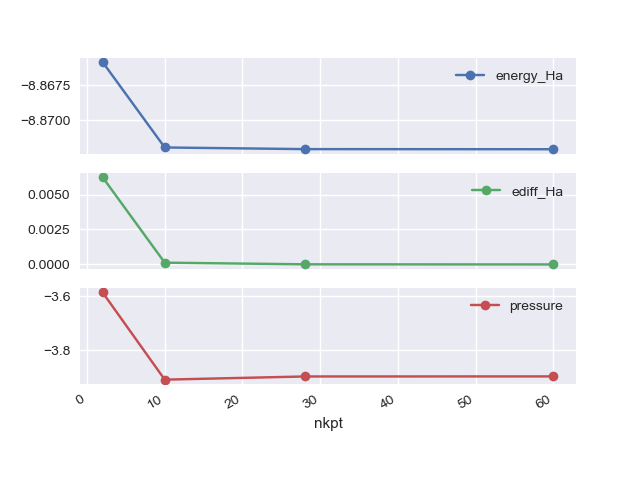

In [14]:
ene_table.plot(x="nkpt", y=["energy_Ha", "ediff_Ha", "pressure"], style="-o", subplots=True);

The difference between dataset 3 and dataset 4 is rather small. Even the dataset 2 gives an accuracy of about 0.0001 Ha.
So, our converged value for the total energy (at fixed `acell` and `ecut`) is -8.8726 Ha.

Now that we have learned a bit how to use pandas `Dataframes`, we can finally reveal
that the AbiPy robots *already* provide methods to perform this kind of convergence studies 
so that we do not need to manipulate pandas dataframes explicitly.
For example, we can perform the same analysis with a single line:

<IPython.core.display.Javascript object>


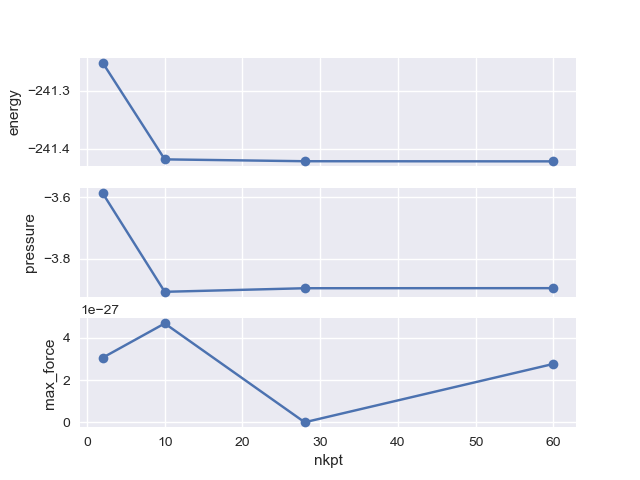

In [15]:
robot_enekpt.plot_gsr_convergence(sortby="nkpt");

We can also pass a function that will be called by the robot to compute the values along the x-axis 
and sort the results.
The docstring of the function is used as label of the x-axis:

<IPython.core.display.Javascript object>


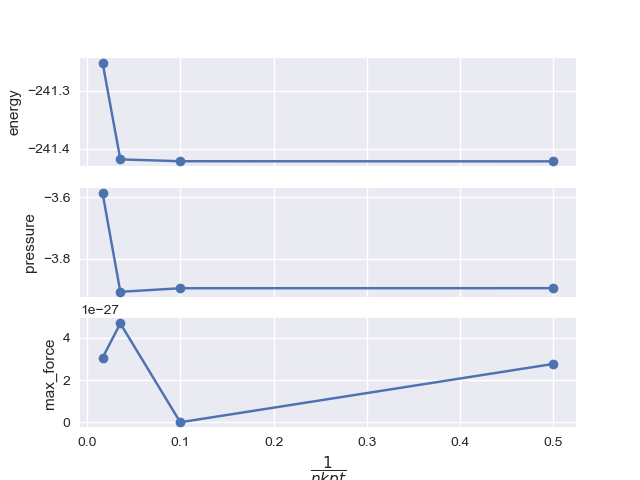

In [16]:
def inv_nkpt(abifile):
    r"""$\dfrac{1}{nkpt}$"""
    return 1 / abifile.nkpt
    
robot_enekpt.plot_gsr_convergence(sortby=inv_nkpt);    

In [17]:
#robot_enekpt.plot_lattice_convergence(sortby="nkpt");

## Determination of the lattice parameters
[[back to top](#top)]

At this point, the original Abinit tutorial proceeds with a convergence study for the optimized
lattice parameters as function of the k-point sampling.
In AbiPy, we only need to build different relaxation tasks with a slightly different input
in which only `ngkpt` is changed.

In [18]:
from lesson_base3 import build_relax_flow
abilab.print_source(build_relax_flow)

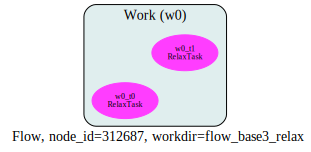

In [19]:
relax_flow = build_relax_flow(options=None)
relax_flow.get_graphviz()

<div class="alert alert-info">
If you want to run the flow from the shell, open lesson_base3.py and change the main function
so that it calls build_relax_flow instead of build_ngkpt_flow.
</div>

This is our first structural relaxation with AbiPy and this gives us the opportunity to introduce the `HIST.nc` file.
This file stores the history of the relaxation 
(energies, forces, stresses, lattice parameters and atomic positions at the different relaxation steps).

As usual, we use `abiopen` to generate an AbiPy object:

In [21]:
hist = abilab.abiopen("flow_base3_relax/w0/t1/outdata/out_HIST.nc")
print(hist)

================================= File Info =================================
Name: out_HIST.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/base3/flow_base3_relax/w0/t1/outdata
Size: 4.24 kb
Access Time: Fri Mar 16 21:16:34 2018
Modification Time: Wed Oct 11 00:28:35 2017
Change Time: Wed Oct 11 00:28:35 2017

============================= Initial Structure =============================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [ 4.10231606e-27 -5.80155101e-27 -3.31586260e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [-4.10231606e-27  5.80155101e-27  3.31586260e-27] eV ang^-1

Number of relaxation steps performed: 4
============================== Final structure ==============================
Full Formula (Si2)
Reduced Fo

To plot the evolution of the most important physical quantities, use:

<IPython.core.display.Javascript object>


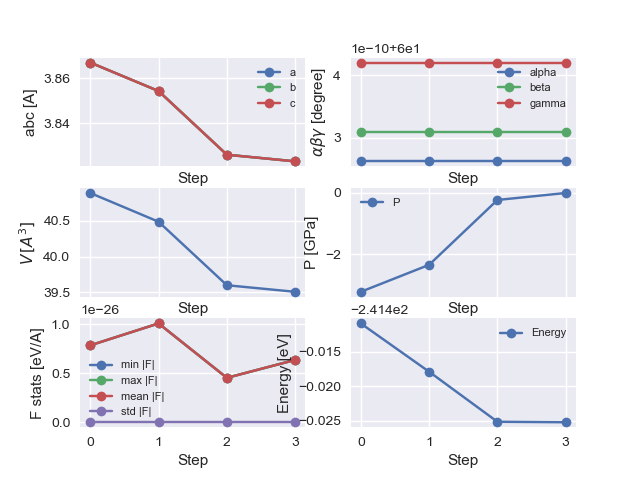

In [22]:
hist.plot();

In [23]:
hist_robot = abilab.HistRobot.from_dir("flow_base3_relax")
    
hist_table = hist_robot.get_dataframe()

There are several entries in the `DataFrame`:

In [24]:
hist_table.keys()

Index(['formula', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c', 'volume',
       'abispg_num', 'spglib_symb', 'spglib_num', 'num_steps', 'final_energy',
       'final_pressure', 'final_fmin', 'final_fmax', 'final_fmean',
       'final_fstd', 'final_drift', 'initial_fmin', 'initial_fmax',
       'initial_fmean', 'initial_fstd', 'initial_drift'],
      dtype='object')

Let's select some of them with:

In [25]:
hist_table[["alpha", "a", "final_energy", "final_pressure", "num_steps"]]

,alpha,a,final_energy,final_pressure,num_steps
w0/t0/outdata/out_HIST.nc,60.0,3.829282,-241.255628,-0.013259,4
w0/t1/outdata/out_HIST.nc,60.0,3.822962,-241.425215,-0.008757,4


and print the evolution of important physical properties extracted from the two files: 

<IPython.core.display.Javascript object>


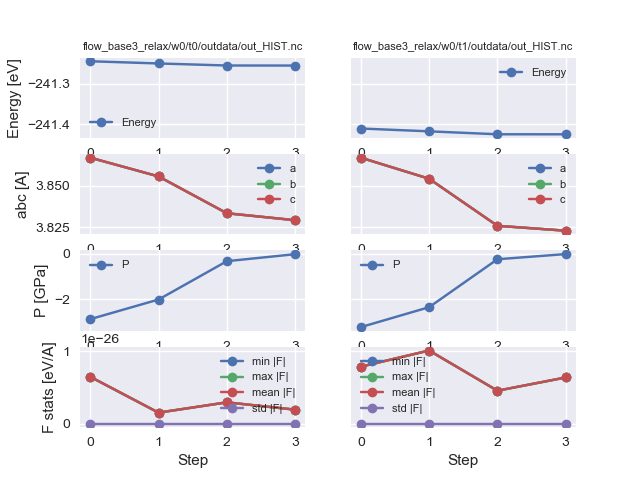

In [26]:
hist_robot.gridplot(what_list=["energy", "abc", "pressure", "forces"]);

We can also compare the two structural relaxations with:

<IPython.core.display.Javascript object>


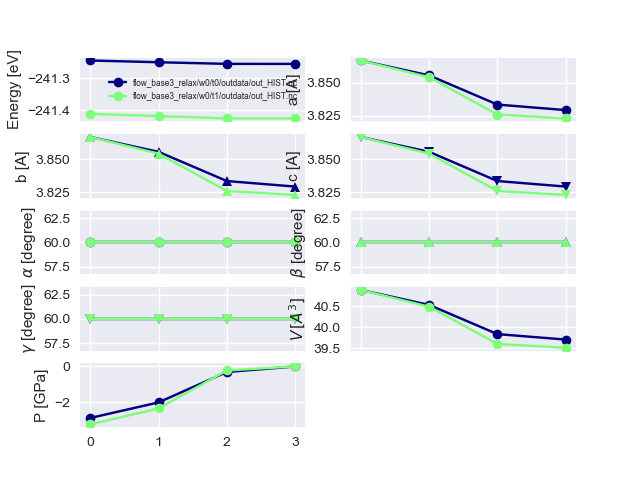

In [27]:
hist_robot.combiplot();

Unfortunately the `HIST.nc` file does not have enough metadata. 
In particular we would like to have information about the k-point sampling 
so that we can analyze the convergence of the optimized lattice parameters wrt `nkpt`.
Fortunately the `GSR.nc` has all the information we need and it is just a matter
of replacing the `HistRobot` with a `GsrRobot`:

In [28]:
with abilab.GsrRobot.from_dir("flow_base3_relax") as relkpt_robot:
    relax_table = relkpt_robot.get_dataframe().sort_values(by="nkpt")
    dfs = relkpt_robot.get_structure_dataframes()

In [29]:
relax_table[["energy", "a", "pressure", "max_force", "pressure"]]

,energy,a,pressure,max_force,pressure
w0/t0/outdata/out_GSR.nc,-241.255628,3.829282,-0.013259,1.913429e-27,-0.013259
w0/t1/outdata/out_GSR.nc,-241.425215,3.822962,-0.008757,6.356619e-27,-0.008757


Plotting the energy, the lattice parameter `a` in Bohr and the pressure in `GPa` vs `nkpt` is really a piece of cake!

<IPython.core.display.Javascript object>


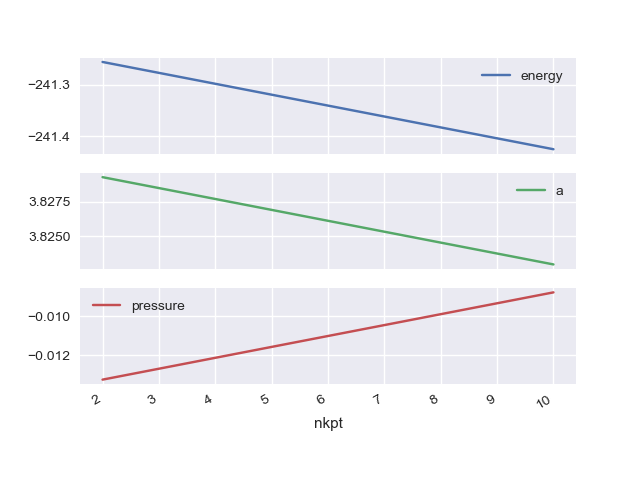

In [30]:
relax_table.plot(x="nkpt", y=["energy", "a", "pressure"], subplots=True);

Alternatively, one can use the `GsrRobot` API:

<IPython.core.display.Javascript object>


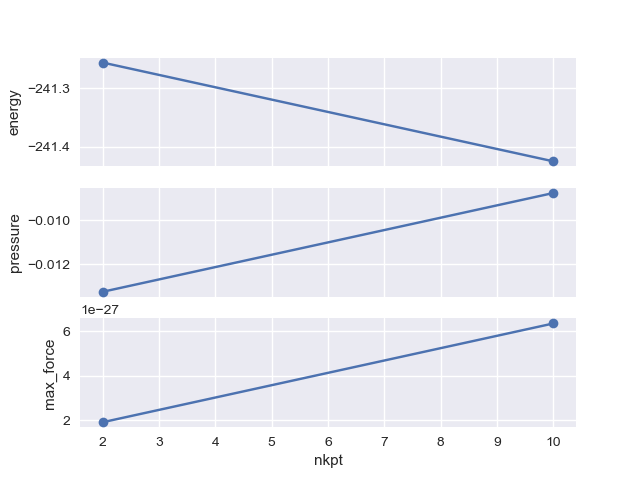

In [31]:
relkpt_robot.plot_gsr_convergence(sortby="nkpt");

<IPython.core.display.Javascript object>


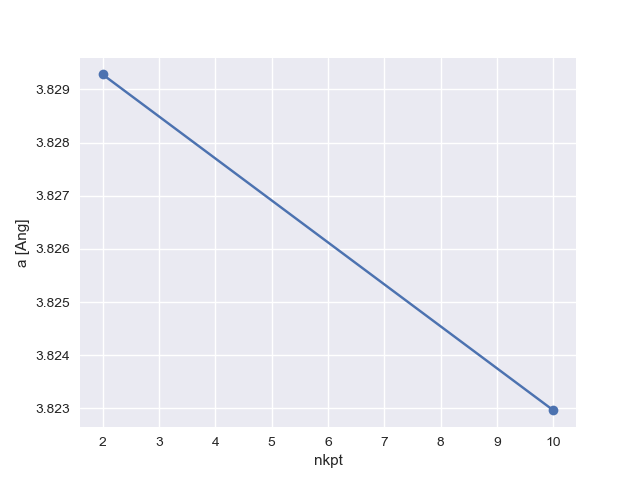

In [32]:
relkpt_robot.plot_lattice_convergence(what_list=["a"], sortby="nkpt");

We fix the parameters `acell` to the theoretical value of 3*10.216, 
and we fix also the grid of k points 
(the 4x4x4 FCC grid, equivalent to a 8x8x8 Monkhorst-pack grid).
We will ask for 8 bands (4 valence and 4 conduction).

## Computing the band structure
[[back to top](#top)]

A band structure can be computed by solving the Kohn-Sham equation for many different k points, along different lines of the Brillouin zone.
The potential that enters the Kohn-Sham equation must be derived from a previous self-consistent calculation, 
and will not vary during the scan of different k-point lines.

This is our first Flow with dependencies in the sense that the band structure calculation must be 
connected to a previous SCF run. 
Fortunately AbiPy provides a factory function to generate this kind of workflow.
We only need to focus on the definition of the two inputs:

In [33]:
from lesson_base3 import build_ebands_flow
abilab.print_source(build_ebands_flow)

The `Flow` consists of a single `Work` with two `Tasks` 
(`ScfTask` with a k-mesh and a `NscfTask` performed on the k-path).

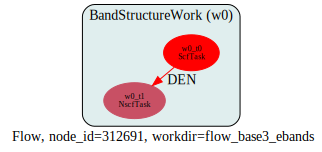

In [34]:
ebands_flow = build_ebands_flow(options=None)
ebands_flow.get_graphviz()

<div class="alert alert-info">
If you want to run the flow from the shell, open lesson_base3.py and change the main function
so that it calls build_ebands_flow.
</div>

Let's extract the band structure from the `GSR.nc` file produced by the `NscfTask`:

In [35]:
with abilab.abiopen("flow_base3_ebands/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands

and plot it with:

<IPython.core.display.Javascript object>


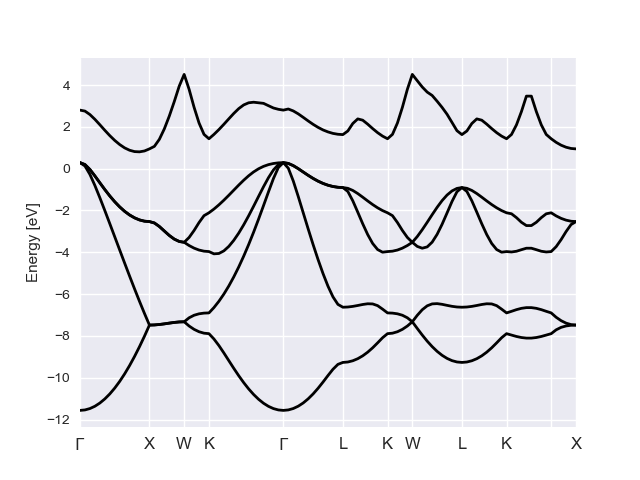

In [36]:
ebands_kpath.plot();

The width of the valence band is 12.09 eV, the lowest unoccupied state at X is 0.594 eV higher than the top of the valence band, at Gamma. Bulk silicon is described as an indirect band gap material (this is correct), with a band-gap of about 0.594 eV (this is quantitatively quite wrong: the experimental value 1.17 eV is at 25 degree Celsius). The minimum of the conduction band is even slightly displaced with respect to X, see kpt # 21. 

This underestimation of the band gap is well-known (the famous DFT band-gap problem). 
In order to obtain correct band gaps, you need to go beyond the Kohn-Sham Density Functional Theory: 
use the $GW$ approximation. 
This is described in the first lesson on the $GW$ approximation.

We can also plot the k-path in the Brillouin zone with:

<IPython.core.display.Javascript object>


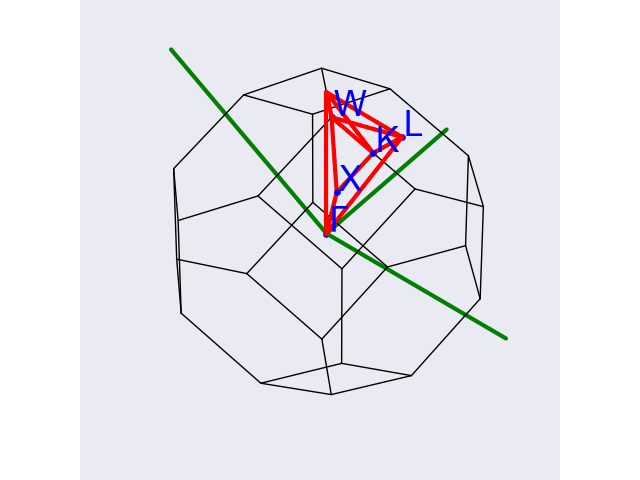

In [37]:
ebands_kpath.kpoints.plot();

The `GSR` file produced by the first task contains energies on a homogeneous k-mesh.
We can therefore compute the DOS by invoking the `get_edos` method:

In [38]:
with abilab.abiopen("flow_base3_ebands/w0/t0/outdata/out_GSR.nc") as gsr:
    ebands_kmesh = gsr.ebands
    
edos = ebands_kmesh.get_edos()

and plot the DOS with:

<IPython.core.display.Javascript object>


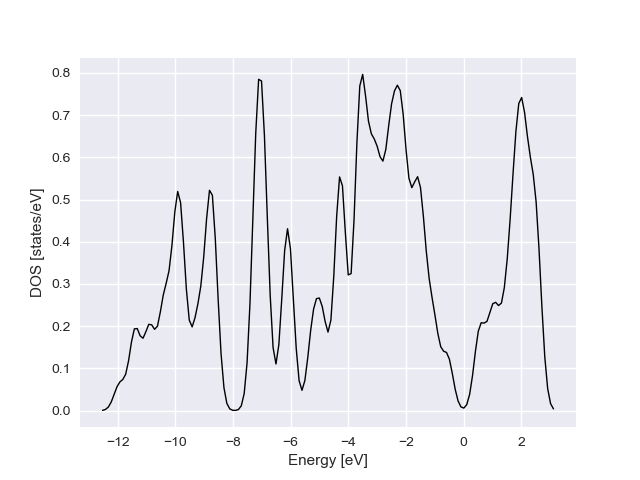

In [39]:
edos.plot();

where the zero of the energy axis is set to the Fermi level $\epsilon_F$ obtained by solving:
    
$$\int_{-\infty}^{\epsilon_F} g(\epsilon)\,d\epsilon = N$$

for $\epsilon_F$ with $N$ the number of electrons per unit cell.

Want to make  a nice picture of the band dispersion with a second panel for the DOS?

<IPython.core.display.Javascript object>


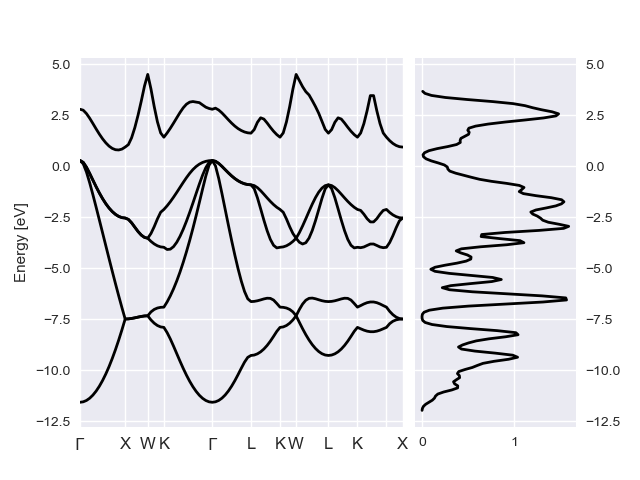

In [40]:
ebands_kpath.plot_with_edos(edos);

Stop reading now and look at the bands + DOS plot carefully. 
Do you see anything weird?

<IPython.core.display.Javascript object>


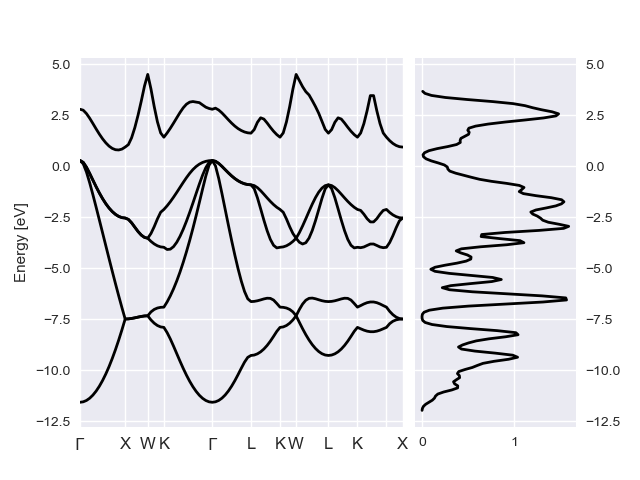

In [41]:
ebands_kpath.plot_with_edos(edos, e0=ebands_kpath.fermie);

In [42]:
print(ebands_kmesh.fermie, ebands_kpath.fermie, edos.fermie)

5.280063055928883 5.280063055928883 5.838293265593386


Back to the main [Index](../index.ipynb)